In [4]:
import os
import pandas as pd
import numpy as np
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import plotly as py
import math
import PAMI
import umap
%matplotlib inline
os.chdir('D://DM_lab1_repo//DM2024-Lab1-Master') 
import helpers.data_mining_helpers as dmh

%load_ext autoreload
%autoreload 2

from datasets import load_dataset

ds = load_dataset("Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data")

In [5]:
# Data Preparation

In [6]:
print(ds["train"][0])
dsTrain = ds["train"]
print(dsTrain.features)
ds_shuffled = dsTrain.shuffle(seed=42)

{'sentiment': 'not nostalgia', 'comment': 'He was a singer with a golden voice that I love to hear all the time. I was his great fan at the age of 16years in those days and still now. Although we have many singers now, but, I can vouch for Jim Reeves all the time. You feel relaxed, emotional and loving. Thank you Lord for his life.'}
{'sentiment': Value(dtype='string', id=None), 'comment': Value(dtype='string', id=None)}


In [7]:
for i in dsTrain.data[:2]["comment"]:
    print(i)

print("---")

for i in dsTrain.data[:2]["sentiment"]:
    print(i)

He was a singer with a golden voice that I love to hear all the time. I was his great fan at the age of 16years in those days and still now. Although we have many singers now, but, I can vouch for Jim Reeves all the time. You feel relaxed, emotional and loving. Thank you Lord for his life.
The mist beautiful voice ever I listened to him when I was a kid and still love his singing Never forgotten The voice of an angel
---
not nostalgia
nostalgia


In [8]:
# Data Transformation

In [9]:
sentiments = [x.as_py() for x in dsTrain.data['sentiment']]
comments = [x.as_py() for x in dsTrain.data['comment']]
analysis = pd.DataFrame(sentiments, columns=["sentiment"])
type(analysis)

pandas.core.frame.DataFrame

In [10]:
analysis["comment"] = comments
print(analysis[:5])

       sentiment                                            comment
0  not nostalgia  He was a singer with a golden voice that I lov...
1      nostalgia  The mist beautiful voice ever I listened to hi...
2      nostalgia  I have most of Mr. Reeves songs.  Always love ...
3  not nostalgia  30 day leave from 1st tour in Viet Nam to conv...
4      nostalgia  listening to his songs reminds me of my mum wh...


In [11]:
analysis[:5][["sentiment", "comment"]]

,sentiment,comment
0,not nostalgia,He was a singer with a golden voice that I lov...
1,nostalgia,The mist beautiful voice ever I listened to hi...
2,nostalgia,I have most of Mr. Reeves songs. Always love ...
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...
4,nostalgia,listening to his songs reminds me of my mum wh...


In [12]:
analysis.iloc[:5, 1]

0    He was a singer with a golden voice that I lov...
1    The mist beautiful voice ever I listened to hi...
2    I have most of Mr. Reeves songs.  Always love ...
3    30 day leave from 1st tour in Viet Nam to conv...
4    listening to his songs reminds me of my mum wh...
Name: comment, dtype: object

In [13]:
analysis.isnull().apply(lambda x: dmh.check_missing_values(x))

,sentiment,comment
0,The amoung of missing records is:,The amoung of missing records is:
1,0,0


In [14]:
dummySeries = pd.Series(["dummyRecord", 1], ["sentiment", "comment"]) 
dummySeries

sentiment    dummyRecord
comment                1
dtype: object

In [15]:
dummySeries.to_frame().T

,sentiment,comment
0,dummyRecord,1


In [16]:
dummyAnalysis = pd.concat([analysis, dummySeries.to_frame().T], ignore_index=True)
len(dummyAnalysis)

1501

In [17]:
dummyDict = [{'comment': 'dummy_record'}]
analysis = pd.concat([analysis, pd.DataFrame(dummyDict)], ignore_index=True)
len(analysis)

1501

In [18]:
analysis.isnull().apply(lambda x: dmh.check_missing_values(x))

,sentiment,comment
0,The amoung of missing records is:,The amoung of missing records is:
1,1,0


In [19]:
analysis.dropna(inplace=True)
analysis.isnull().apply(lambda x: dmh.check_missing_values(x))

,sentiment,comment
0,The amoung of missing records is:,The amoung of missing records is:
1,0,0


In [20]:
analysis.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Length: 1500, dtype: bool

In [21]:
ttl = sum(analysis.duplicated())
cm = sum(analysis.duplicated("comment"))
print("ttl: ", ttl, "comment: ", cm)

ttl:  1 comment:  1


In [22]:
analysis.drop_duplicates(keep=False, inplace=True)
len(analysis)

1498

In [23]:
# Data Preprocessing

In [24]:
analysisSample = analysis.sample(n = 1000)
len(analysisSample)

1000

In [25]:
analysisSample[:5]

,sentiment,comment
1452,not nostalgia,I love his music and always have. Beautiful vo...
492,nostalgia,"My mother, an incurable romantic from Belfast,..."
151,not nostalgia,my name is thomas but know by tommy and my wif...
1288,not nostalgia,"this music make up my day ,I real love listeni..."
1166,not nostalgia,"Young, gifted and well done for doing what a l..."


sentiment
nostalgia        750
not nostalgia    748
Name: count, dtype: int64


<Axes: title={'center': 'Category distribution'}, xlabel='sentiment'>

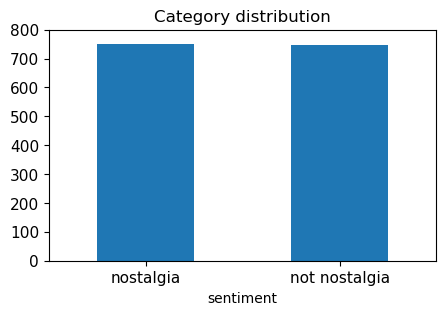

In [26]:
print(analysis.sentiment.value_counts())
analysis.sentiment.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution',
                                    ylim = [0, 800],        
                                    rot = 0, fontsize = 11, figsize = (5,3))

sentiment
not nostalgia    504
nostalgia        496
Name: count, dtype: int64


<Axes: title={'center': 'Category distribution'}, xlabel='sentiment'>

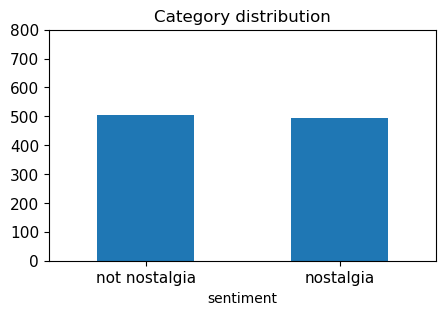

In [27]:
print(analysisSample.sentiment.value_counts())
analysisSample.sentiment.value_counts().plot(kind = 'bar',
                                    title = 'Category distribution',
                                    ylim = [0, 800],        
                                    rot = 0, fontsize = 11, figsize = (5,3))

In [28]:
analysis["unigrams"] = analysis["comment"].apply(lambda x: dmh.tokenize_text(x))

In [29]:
analysis[:5]["unigrams"]

0    [He, was, a, singer, with, a, golden, voice, t...
1    [The, mist, beautiful, voice, ever, I, listene...
2    [I, have, most, of, Mr., Reeves, songs, ., Alw...
3    [30, day, leave, from, 1st, tour, in, Viet, Na...
4    [listening, to, his, songs, reminds, me, of, m...
Name: unigrams, dtype: object

In [30]:
analysis[:5]

,sentiment,comment,unigrams
0,not nostalgia,He was a singer with a golden voice that I lov...,"[He, was, a, singer, with, a, golden, voice, t..."
1,nostalgia,The mist beautiful voice ever I listened to hi...,"[The, mist, beautiful, voice, ever, I, listene..."
2,nostalgia,I have most of Mr. Reeves songs. Always love ...,"[I, have, most, of, Mr., Reeves, songs, ., Alw..."
3,not nostalgia,30 day leave from 1st tour in Viet Nam to conv...,"[30, day, leave, from, 1st, tour, in, Viet, Na..."
4,nostalgia,listening to his songs reminds me of my mum wh...,"[listening, to, his, songs, reminds, me, of, m..."


In [31]:
list(analysis[:1]["unigrams"])

[['He',
  'was',
  'a',
  'singer',
  'with',
  'a',
  'golden',
  'voice',
  'that',
  'I',
  'love',
  'to',
  'hear',
  'all',
  'the',
  'time',
  '.',
  'I',
  'was',
  'his',
  'great',
  'fan',
  'at',
  'the',
  'age',
  'of',
  '16years',
  'in',
  'those',
  'days',
  'and',
  'still',
  'now',
  '.',
  'Although',
  'we',
  'have',
  'many',
  'singers',
  'now',
  ',',
  'but',
  ',',
  'I',
  'can',
  'vouch',
  'for',
  'Jim',
  'Reeves',
  'all',
  'the',
  'time',
  '.',
  'You',
  'feel',
  'relaxed',
  ',',
  'emotional',
  'and',
  'loving',
  '.',
  'Thank',
  'you',
  'Lord',
  'for',
  'his',
  'life',
  '.']]

In [32]:
count_vect = CountVectorizer()
analysisCounts = count_vect.fit_transform(analysis.comment)
print(analysisCounts[0])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 45 stored elements and shape (1, 3730)>
  Coords	Values
  (0, 1598)	1
  (0, 3570)	2
  (0, 2973)	1
  (0, 3650)	1
  (0, 1470)	1
  (0, 3534)	1
  (0, 3282)	1
  (0, 2028)	1
  (0, 3336)	1
  (0, 1606)	1
  (0, 233)	2
  (0, 3284)	3
  (0, 3328)	2
  (0, 1651)	2
  (0, 1512)	1
  (0, 1249)	1
  (0, 323)	1
  (0, 214)	1
  (0, 2341)	1
  (0, 15)	1
  (0, 1733)	1
  (0, 3304)	1
  (0, 907)	1
  (0, 258)	2
  (0, 3124)	1
  (0, 2328)	2
  (0, 245)	1
  (0, 3581)	1
  (0, 1591)	1
  (0, 2082)	1
  (0, 2974)	1
  (0, 573)	1
  (0, 593)	1
  (0, 3538)	1
  (0, 1347)	2
  (0, 1833)	1
  (0, 2671)	1
  (0, 3713)	2
  (0, 1272)	1
  (0, 2688)	1
  (0, 1125)	1
  (0, 2035)	1
  (0, 3278)	1
  (0, 2018)	1
  (0, 1964)	1


In [33]:
count_vect.get_feature_names_out()[1606]

'hear'

In [34]:
count_vect.get_feature_names_out()[2688]

'relaxed'

In [35]:
textAnalyze =  count_vect.build_analyzer()
textAnalyze("I am craving for a hawaiian pizza right now")

['am', 'craving', 'for', 'hawaiian', 'pizza', 'right', 'now']

In [36]:
test = "\n".join(analysis["unigrams"][0])
print(test)

He
was
a
singer
with
a
golden
voice
that
I
love
to
hear
all
the
time
.
I
was
his
great
fan
at
the
age
of
16years
in
those
days
and
still
now
.
Although
we
have
many
singers
now
,
but
,
I
can
vouch
for
Jim
Reeves
all
the
time
.
You
feel
relaxed
,
emotional
and
loving
.
Thank
you
Lord
for
his
life
.


In [37]:
textAnalyze(test)

['he',
 'was',
 'singer',
 'with',
 'golden',
 'voice',
 'that',
 'love',
 'to',
 'hear',
 'all',
 'the',
 'time',
 'was',
 'his',
 'great',
 'fan',
 'at',
 'the',
 'age',
 'of',
 '16years',
 'in',
 'those',
 'days',
 'and',
 'still',
 'now',
 'although',
 'we',
 'have',
 'many',
 'singers',
 'now',
 'but',
 'can',
 'vouch',
 'for',
 'jim',
 'reeves',
 'all',
 'the',
 'time',
 'you',
 'feel',
 'relaxed',
 'emotional',
 'and',
 'loving',
 'thank',
 'you',
 'lord',
 'for',
 'his',
 'life']

In [38]:
analysisCounts.shape

(1498, 3730)

In [39]:
count_vect.get_feature_names_out()[600:611]

array(['captial', 'captivating', 'captured', 'car', 'cardiff', 'care',
       'cared', 'carefree', 'careful', 'carefully', 'cares'], dtype=object)

In [40]:
analysisCounts[:5, :100].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [41]:
plotX = ["term_" + str(i) for i in count_vect.get_feature_names_out()[:20]]
plotY = ["doc_" + str(i) for i in list(analysis.index)[:20]]
plotZ = analysisCounts[:20, :20].toarray()
plotZ

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
print(plotX)

In [ ]:
print(plotY)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dfPlot = pd.DataFrame(plotZ, columns = plotX, index = plotY)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(dfPlot,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

In [ ]:
term_frequencies = []
for j in range(0,analysisCounts.shape[1]):
    term_frequencies.append(sum(analysisCounts[:,j].toarray()))

In [ ]:
term_frequencies = np.asarray(analysisCounts.sum(axis=0))[0]
print(term_frequencies[4])

In [ ]:
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300], 
            y=term_frequencies[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

In [ ]:
term_frequencies_log = [math.log(i) for i in term_frequencies]
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
                y=term_frequencies_log[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

In [ ]:
categories = analysis["sentiment"].unique()
category_dfs = {}  
for category in categories:
    # Filter the original DataFrame by category
    category_dfs[category] = analysis[analysis["sentiment"] == category].copy()
 # Function to create term-document frequency DataFrame for each category
def create_term_document_df(df):
    count_vect = CountVectorizer()  # Initialize the CountVectorizer
    analysisCounts = count_vect.fit_transform(df["comment"])  # Transform the text data into word counts
    
    # Get the unique words (vocabulary) from the vectorizer
    words = count_vect.get_feature_names_out()
    
    # Create a DataFrame where rows are documents and columns are words
    term_document_df = pd.DataFrame(analysisCounts.toarray(), columns=words)
    
    return term_document_df
 # Create term-document frequency DataFrames for each category
term_document_dfs = {}  # Dictionary to store term-document DataFrames for each category
for category in categories:
    term_document_dfs[category] = create_term_document_df(category_dfs[category])

In [ ]:
category_number = 1
print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
term_document_dfs[categories[category_number]]

In [ ]:
category_number = 1
word_counts = term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()
 
# Visualize the frequency distribution
plt.figure(figsize = (8, 6))
plt.hist(word_counts, bins = 3000, color = 'black', edgecolor = 'red')
plt.title(f'Term Frequency Distribution for Category {categories[category_number]}')
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.xlim(1, 170)
plt.show()

In [ ]:
category_number = 1
word_counts = term_document_dfs[categories[category_number]].sum(axis = 0).to_numpy()

sorted_indices = np.argsort(word_counts)
sorted_counts = np.sort(word_counts)[::-1]

total_terms = len(sorted_counts)
top_5_percent_index = int(0.05 * total_terms)

top_5_percent_indices = sorted_indices[:top_5_percent_index]

filtered_words = [count_vect.get_feature_names_out()[i] for i in top_5_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in top 5%: {top_5_percent_index}")
print(f"Filtered terms: {filtered_words}")

In [ ]:
category_number = 1
word_counts = term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()

sorted_indices = np.argsort(word_counts) 
sorted_counts = word_counts[sorted_indices] 

total_terms = len(sorted_counts)
bottom_1_percent_index = int(0.01 * total_terms)

bottom_1_percent_indices = sorted_indices[:bottom_1_percent_index]

filtered_words = [count_vect.get_feature_names_out()[i] for i in bottom_1_percent_indices]

print(f"Category: {categories[category_number]}")
print(f"Number of terms in bottom 1%: {bottom_1_percent_index}")
print(f"Filtered terms: {filtered_words}")

In [ ]:
#移除極端情形
category_number = 1

def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):
    word_sums = term_document_df.sum(axis=0)
    
    sorted_words = word_sums.sort_values()
    
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words)
    bottom_n = int(bottom_percent * total_words)
    
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index
    
    return term_document_df.drop(columns=words_to_remove)

filtered_term_document_dfs = {}

for category in categories:
    filtered_term_document_dfs[category] = filter_top_bottom_words_by_sum(term_document_dfs[category])
term_document_dfs=filtered_term_document_dfs

print(f"Filtered Term-Document Frequency DataFrame for Category {categories[category_number]}:")
filtered_term_document_dfs[categories[category_number]]

In [ ]:
from PAMI.extras.DF2DB import DenseFormatDF as db

for category in term_document_dfs:

    category_safe = category.replace('.', '_')

    print(category_safe)
    
    obj = db.DenseFormatDF(term_document_dfs[category])
    obj.convert2TransactionalDatabase(f'td_freq_db_{category_safe}.csv', '>=', 1)

In [ ]:
from PAMI.extras.dbStats import TransactionalDatabase as tds
obj = tds.TransactionalDatabase('td_freq_db_nostalgia.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

In [ ]:
obj = tds.TransactionalDatabase('td_freq_db_not nostalgia.csv')
obj.run()
obj.printStats()
obj.plotGraphs()

In [ ]:
from PAMI.frequentPattern.basic import FPGrowth as alg
minSup = 5
obj1 = alg.FPGrowth(iFile='td_freq_db_not nostalgia.csv', minSup = minSup)
obj1.mine()
frequentPatternsDF_notNostalgia= obj1.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_notNostalgia))) 
print('Runtime: ' + str(obj1.getRuntime()))

In [ ]:
minSup = 6
obj1 = alg.FPGrowth(iFile='td_freq_db_nostalgia.csv', minSup = minSup)
obj1.mine()
frequentPatternsDF_nostalgia= obj1.getPatternsAsDataFrame()
print('Total No of patterns: ' + str(len(frequentPatternsDF_nostalgia))) 
print('Runtime: ' + str(obj1.getRuntime()))

In [ ]:
obj1.save('freq_patterns_notNostalgia_minSup9.txt')
frequentPatternsDF_notNostalgia

In [ ]:
obj1.save('freq_patterns_nostalgia_minSup9.txt')
frequentPatternsDF_nostalgia

In [ ]:
dfs = [frequentPatternsDF_notNostalgia, frequentPatternsDF_nostalgia]

pattern_counts = {}
for df in dfs:
    for pattern in df['Patterns']:
        if pattern not in pattern_counts:
            pattern_counts[pattern] = 1
        else:
            pattern_counts[pattern] += 1

unique_patterns = {pattern for pattern, count in pattern_counts.items() if count == 1}

total_patterns_count = sum(len(df) for df in dfs)

discarded_patterns_count = total_patterns_count - len(unique_patterns)

filtered_dfs = []

for df in dfs:
    filtered_df = df[df['Patterns'].isin(unique_patterns)]
    filtered_dfs.append(filtered_df)

final_pattern_df = pd.concat(filtered_dfs, ignore_index=True)

final_pattern_df = final_pattern_df.sort_values(by='Support', ascending=False)

print(final_pattern_df)

print(f"Number of patterns discarded: {discarded_patterns_count}")

In [ ]:
count_vect = CountVectorizer()

analysis_tdm = count_vect.fit_transform(analysis["comment"])
terms = count_vect.get_feature_names_out()

analysis['tokenized_comment'] = analysis["comment"].str.split().apply(set)

pattern_matrix = pd.DataFrame(0, index = analysis.index, columns = final_pattern_df['Patterns'])

for pattern in final_pattern_df['Patterns']:
    pattern_words = set(pattern.split())
    pattern_matrix[pattern] = analysis['tokenized_comment'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)

tdm_df = pd.DataFrame(analysis_tdm.toarray(), columns = terms, index = analysis.index)

augmented_df = pd.concat([tdm_df, pattern_matrix], axis = 1)
augmented_df

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

ana_pca_tdm = PCA(n_components=2).fit_transform(tdm_df.values)
ana_tsne_tdm = TSNE(n_components=2).fit_transform(tdm_df.values)
ana_umap_tdm = umap.UMAP(n_components=2).fit_transform(tdm_df.values)

In [ ]:
ana_pca_tdm.shape

In [ ]:
ana_tsne_tdm.shape

In [ ]:
ana_umap_tdm.shape

In [ ]:
col = ['coral', 'blue']
categories = analysis['sentiment'].unique() 
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('PCA, t-SNE, and UMAP Comparison')

def plot_scatter(ax, ana_reduced, title):
    for c, category in zip(col, categories):
        xs = ana_reduced[analysis['sentiment'] == category].T[0]
        ys = ana_reduced[analysis['sentiment'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')
# Step 4: Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], ana_pca_tdm, 'PCA')
plot_scatter(axes[1], ana_tsne_tdm, 't-SNE')
plot_scatter(axes[2], ana_umap_tdm, 'UMAP')
plt.show()

In [ ]:
ana_pca_aug = PCA(n_components=2).fit_transform(augmented_df.values)
ana_tsne_aug = TSNE(n_components=2).fit_transform(augmented_df.values)
ana_umap_aug = umap.UMAP(n_components=2).fit_transform(augmented_df.values)

In [ ]:
col = ['coral', 'blue']
categories = analysis['sentiment'].unique() 
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

fig.suptitle('PCA, t-SNE, and UMAP Comparison')

def plot_scatter(ax, ana_reduced, title):
    for c, category in zip(col, categories):
        xs = ana_reduced[analysis['sentiment'] == category].T[0]
        ys = ana_reduced[analysis['sentiment'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')
# Create scatter plots for PCA, t-SNE, and UMAP
plot_scatter(axes[0], ana_pca_aug, 'PCA')
plot_scatter(axes[1], ana_tsne_aug, 't-SNE')
plot_scatter(axes[2], ana_umap_aug, 'UMAP')
plt.show()

In [ ]:
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy

In [ ]:
mlb = preprocessing.LabelBinarizer()

In [ ]:
mlb.fit(analysis.sentiment)

In [ ]:
analysis['bin_category'] = mlb.transform(analysis['sentiment']).tolist()

In [ ]:
analysis[:5]

In [ ]:
# Data Exploration

In [ ]:
doc2transform_1 = []
random_record_1 = analysis.iloc[50]
random_record_1 = random_record_1['comment']
doc2transform_1.append(random_record_1)

doc2transform_2 = []
random_record_2 = analysis.iloc[60]
random_record_2 = random_record_2['comment']
doc2transform_2.append(random_record_2)

doc2transform_3 = []
random_record_3 = analysis.iloc[80]
random_record_3 = random_record_3['comment']
doc2transform_3.append(random_record_3)

In [ ]:
print(doc2transform_1)
print(doc2transform_2)
print(doc2transform_3)

In [ ]:
from sklearn.preprocessing import binarize

document_vector_count_1 = count_vect.transform(doc2transform_1)
document_vector_count_2 = count_vect.transform(doc2transform_2)
document_vector_count_3 = count_vect.transform(doc2transform_3)

document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

In [ ]:
# Data Classification

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
analysis['bin_category'] = analysis['bin_category'].apply(lambda x: x[0] if isinstance(x, list) else x)

category_mapping = dict(analysis[['bin_category', 'sentiment']].drop_duplicates().values)

target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]

X_train, X_test, y_train, y_test = train_test_split(tdm_df, analysis['sentiment'], test_size=0.3, random_state=42)

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
y_train

In [ ]:
y_test

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

In [ ]:
# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()

tfidf_matrix = tfidf_vect.fit_transform(analysis['comment'])  # 生成 TF-IDF 特徵矩陣

tfidf_features = tfidf_vect.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)

print(tfidf_df.head())

In [ ]:
# 降維後TF_IDF資料的散佈圖
tfidf_pca = PCA(n_components=2).fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(9, 7))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], alpha=0.5)
plt.title("PCA of TF-IDF Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(analysis['comment'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

top_n = 10
top_n_words = tfidf_df.mean().sort_values(ascending=False).head(top_n).index

tfidf_df[top_n_words].mean().sort_values().plot(kind='barh', figsize=(10, 6))
plt.title(f"Top {top_n} Words by Average TF-IDF Weight (Stop Words Removed)")
plt.xlabel("Average TF-IDF Weight")
plt.ylabel("Words")
plt.show()

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_df.mean())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不顯示坐標軸
plt.title("Word Cloud of Average TF-IDF Weights (Stop Words Removed)")
plt.show()

In [ ]:
# two new classifier

In [ ]:
# TF-IDF for GaussianNB

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

# tfidf_matrix

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_matrix, analysis['sentiment'], test_size=0.2, random_state=42)

X_train_tfidf_array = X_train_tfidf.toarray()
X_test_tfidf_array = X_test_tfidf.toarray()

nb_classifier_tfidf = GaussianNB()
nb_classifier_tfidf.fit(X_train_tfidf_array, y_train)

y_pred_tfidf = nb_classifier_tfidf.predict(X_test_tfidf_array)

print("TF-IDF Features - Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tfidf, target_names=target_names, digits=4))


In [ ]:
# TF-IDF for BernoulliNB()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, analysis['sentiment'], test_size=0.2, random_state=42)

# 使用 BernoulliNB 訓練模型
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_train, y_train)

# 預測並評估
y_pred = bernoulli_nb.predict(X_test)

# 顯示精確度和分類報告
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# wf for BernoulliNB

In [ ]:
texts = analysis['comment']
labels = analysis['sentiment']
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3, random_state=42)
vectorizer = CountVectorizer(binary=True)
X_train_tdm = vectorizer.fit_transform(X_train)
X_test_tdm = vectorizer.transform(X_test)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

bnb_classifier = BernoulliNB()
bnb_classifier.fit(X_train_tdm, y_train)

In [ ]:
y_pred = bnb_classifier.predict(X_test_tdm)

print("Accuracy:", accuracy_score(y_test, y_pred))

target_names = ['nostalgia', 'not nostalgia']  # 根據你的類別名稱調整
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_names, digits=4))

In [ ]:
# Comment on the differences below:
# wf - multinomial / wf - bernoulli 
# tf-igf - gaussian

# 1.利用詞頻對 multinomial / Bernoulli NB進行訓練的差異:
    # MultinomialNB 能夠捕捉詞頻的影響，適合處理包含詞數量多的文本，對詞頻和文本長度更敏感
    # BernoulliNB 更加專注於詞是否出現，因此適合文本中詞彙數量相對穩定且重複少的情況
    # 推測因為該sentiment detection文本中詞彙數量較少，故在Bernoulli NB()訓練時表現較佳
# 2.利用TF-IDF對GaussianNB()進行訓練:
    # GaussianNB 適合用於連續型數據（即數值型變量）並假設每個特徵符合正態分佈 (適合典型的統計資料以及連續型數值特徵)
    # 由於TF-IDF 特徵是稀疏矩陣，更非均勻正態分佈，故在這次的訓練中表現效果有限(僅有7成accuracy)
# 3.利用TF-IDF對BernoulliNB()進行訓練:
    # 針對前述對於BernoulliNB()提及的特徵，使用 TF-IDF 時，雖然產生的特徵並非全是二元值，但比起使用GaussianNB()，已取得相對好的效果